<font color=gray>Oracle Cloud Infrastructure Data Science Demo Notebook

Copyright (c) 2021 Oracle, Inc.<br>
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Training a CNN Model to Detect Pneumonia in Patients with X-ray Images  </font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure Data Science Team </font></p>

***

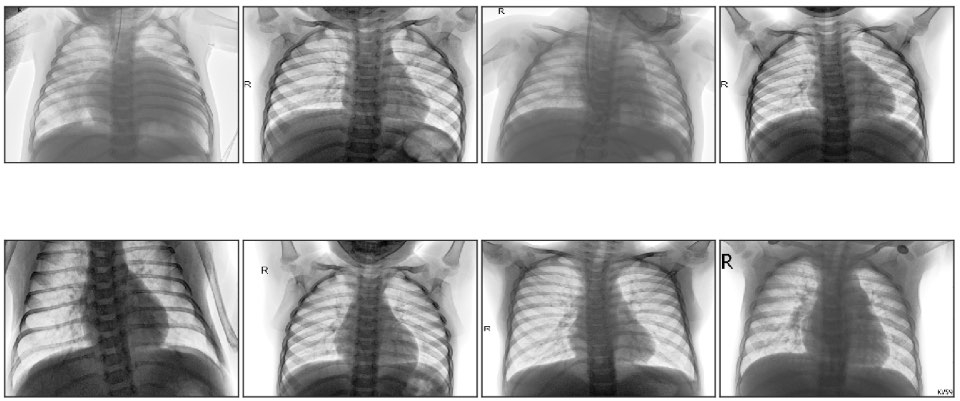

# Introduction 

We're going to see how the Oracle Cloud Infrastructure Data Science service lets us tackle real-world artificial intelligence problems from end to end. To do that we're going to build a complete AI pipeline to detect pneumonia based on a patient's X-ray image. Pneumonia affects about a million Americans a year and causes about 50,000 deaths, making it top ten leading cause of death. It's estimated the US will have a shortage of more than 100,000 physicians by the year 2030. AI will help fill this gap by assisting diagnosis, letting us detect pneumonia earlier, with less reliance on medical specialists.

In this notebook demo we are going to use a convolutional neural network (CNN) to classify chest Xray images of healthy and sick patients (patients with pneumonia). 

## Dataset

We are leveraging the [Labeled Optical Coherence Tomography (OCT) and chest X-ray images](https://data.mendeley.com/datasets/rscbjbr9sj/2) dataset.  of patients for a supervised binary classification task. 

First thing we are going to do is import all the relevant libraries we are going to need, including Keras. 

In [ ]:
#!pip install -r requirements.txt > .install_logs

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image

import keras 
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import plot_model, to_categorical 
from keras.utils import plot_model

from matplotlib import pyplot as plt 
import numpy as np 
import json 
import urllib
from zipfile import ZipFile 
import skimage as ski
import os 
import pandas as pd 
import glob
from numpy import random as random
import urllib 
import tensorflow as tf
from utilities import display_xray_image, display_rows_images, create_df

from skimage import transform 
from IPython.display import Image

import ads
from ads.dataset.factory import DatasetFactory
from ads.common.model import prepare_generic_model
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData

# using resource principal: 
ads.set_auth(auth='resource_principal')
ads.set_debug_mode(mode=False)

import logging 
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

Here we're going to install scikit-image which is a library that is not installed in the notebook environment: 

## Loading the dataset 

The dataset is a zip archive file that we stored on Oracle Cloud Infrastructure Object Storage. We created a pre-authenticated request URL to easily transfer the data onto the notebook container. 

In [ ]:
# unzip the file:
dirpath = f"./data/"
if not os.path.exists(dirpath):
    os.makedirs(dirpath)

In [ ]:
if os.path.exists(os.path.join(dirpath, "chest_xrays.zip")):
    with ZipFile(os.path.join(dirpath, "chest_xrays.zip"), 'r') as zipf:
        zipf.extractall(dirpath)
else:
    data_url = "https://objectstorage.us-ashburn-1.oraclecloud.com/n/bigdatadatasciencelarge/b/hosted-ds-datasets/o/chest-xrays%2FChestXRay2017.zip"
    urllib.request.urlretrieve(data_url,filename=os.path.join(dirpath, "chest_xrays.zip"))
    with ZipFile(os.path.join(dirpath, "chest_xrays.zip"), 'r') as zipf:
        zipf.extractall(dirpath)

The data is divided into a `train/` and a `test/` folder. Each folder has images further separated into the `NORMAL/` and `PNEUMONIA/` medical diagnoses. These folders will serve as labels for our binary classification use case. 

The train set contains 3883 xrays of patients with pneumonia while there are 1349 xray images of patients who do not have the illness. This dataset is considered to be imbalanced for machine learning purposes. 

# Building and Exploring the dataset with ADS DatasetFactory

The first step in the process of training a machine learning model is to build a dataset format that will be understood by the model library. 

We are going to first build a dataframe for both the training and test dataset. The dataset will include metadata about each image. We included the following features: 


* image path
* class(0:normal, 1:pneumonia)
* image dimensions (both x and y) 
* image extension(.jpeg, .png, etc.) 
* number of channels for each image 
* axis ratio (y size / x size ) 

In [ ]:
train_df2 = create_df(dirpath)
ads_df = DatasetFactory.open(train_df2.drop(["resized_image", "original_dims", "dims"], axis=1)).set_target("class")

## Data Profiling 

You can visualize the dataste overall by using our show_in_notebook method. It gives you a comprehensive preview of all the basic information about this dataset, including the type of the dataset (whether it’s a regression, binary classification or multi-class classification dataset), the number of columns and rows, feature types of each columns, visualization of each column, the correlation map as well as a short dataset header.


In [ ]:
ads_df.show_in_notebook()

In [ ]:
ads_df.plot(x="class", y="original_axis_ratio", verbose=False)

In [ ]:
ads_df.plot(x="original_xsize", y="original_ysize")

In the chart below, we leverage ADS to look at the distribution of axis ratios in the orginal images. Axis ratio here is being defined as the y-axis image length divided by the x-axis image length. This information will help us resize these images to a common size without introducing too many distortions. 

In [ ]:
ads_df.plot(x="original_axis_ratio")

## X-ray Images

Let's now take a look at some of the x-ray images in the sample. We pick 8 random xray images from the original sample. 

In [ ]:
display_rows_images(train_df2)

We are going to apply simple transformations to the data before training the model. 

In [ ]:
ads_df.head()

In [ ]:
train_filter = (ads_df['valid']==False).compute()
valid_filter = (ads_df['valid']).compute()

In [ ]:
Xtrain = train_df2[train_filter]['resized_image'].values 
Ytrain = to_categorical(train_df2[train_filter]['class'].values)

Xvalid = train_df2[valid_filter]['resized_image'].values
Yvalid = to_categorical(train_df2[valid_filter]['class'].values)

Xtrain = np.asarray([i.reshape(200,300,1) for i in Xtrain])
Xvalid = np.asarray([i.reshape(200,300,1) for i in Xvalid])

In [ ]:
print("Xtrain shape: {}, Ytrain shape: {}, Xvalid shape: {}, Yvalid shape: {}".format(Xtrain.shape,
                                                                                      Ytrain.shape,
                                                                                      Xvalid.shape,
                                                                                      Yvalid.shape))

# Training a Convolutional Neural Network (CNN) Model with Keras

In the cell below we are defining the CNN model. It is a very simple model with two convolutional layers, 
each followed by a max pooling layers and a dropout layer. 

This simple architecture achieves resonable performance on a holdout/testing dataset as we will see below. 

As an exercise, you may want to explore how transfer learning could be leveraged in this scenario. A different 
network architecture could also be explored. 

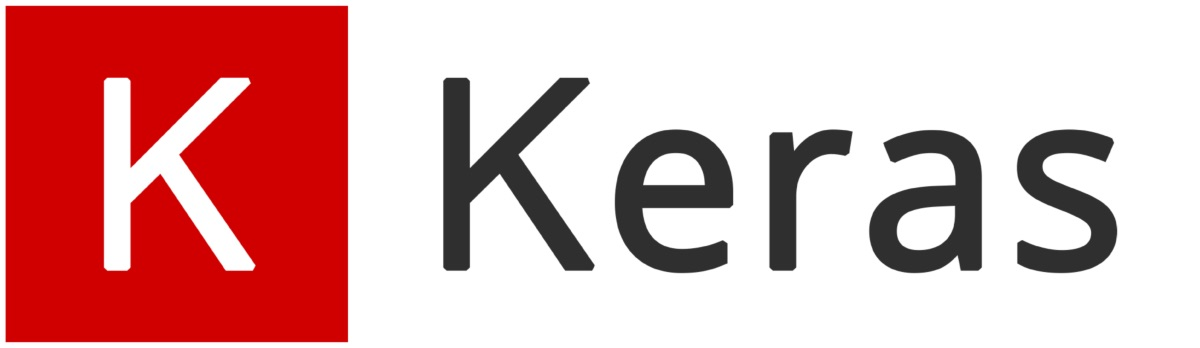

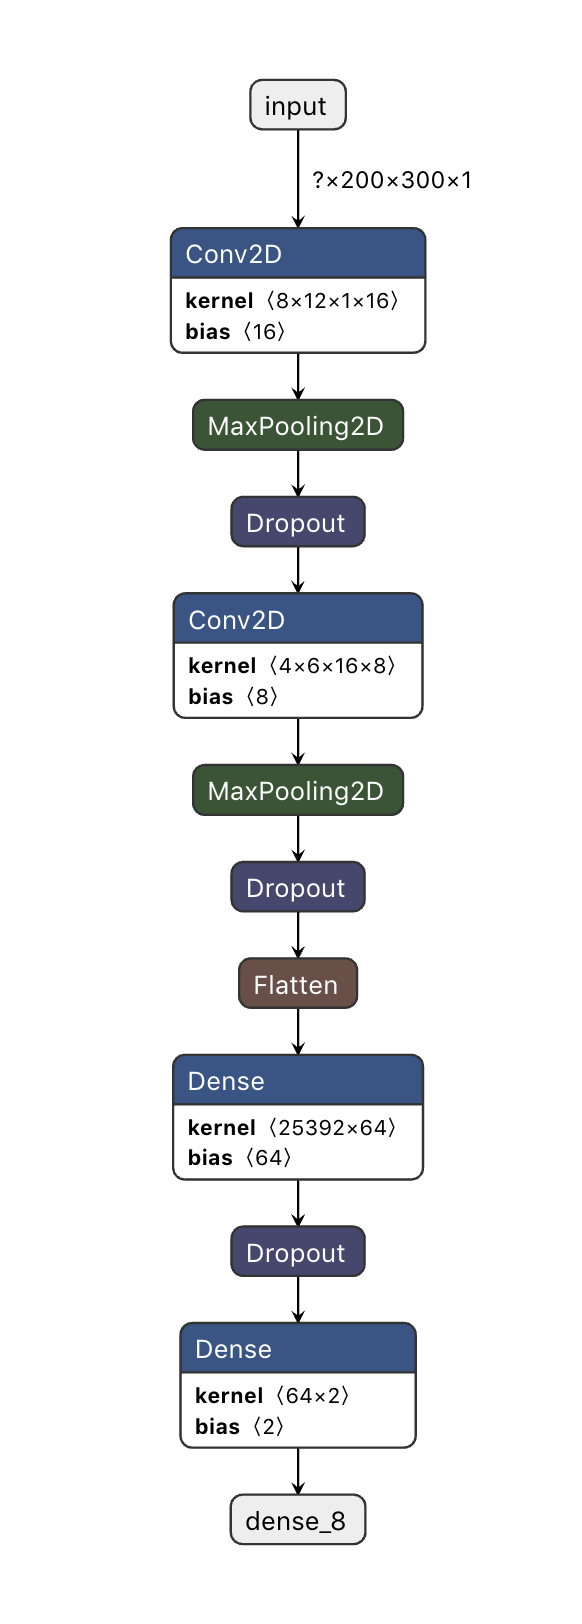

## Model Template Definition

In [ ]:
def simple_custom_CNN_definition(nb_conv_layers=(32,16), 
                            kernel_size1=(4,6), 
                            kernel_size2=(2,3), 
                            nb_dense=128):
    """Simple CNN model we will use to classify images. 
    
    Args: 
    
    nb_conv_layers: number conv layers
    type: tuple 
    
    kernel_size1: size of the first convolutional kernel 
    type: tuple 
    
    kernel_size2: size of the second convolutional kernel 
    type: tuple 
    
    nb_dense: nb of nodes in the fully connected layer 
    type: int 
    
    Returns: 
    
    Keras model 
    """
    model = Sequential()

    # Convolution layer (4x8), 32 filters 
    model.add(Conv2D(nb_conv_layers[0], 
                     kernel_size=kernel_size1, 
                     activation='relu', 
                     input_shape=(200, 300, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolution layer (2x4), 16 filters 
    model.add(Conv2D(nb_conv_layers[1], 
                     kernel_size=kernel_size2, 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    # DNN FC layer: 
    model.add(Dense(nb_dense, activation='relu'))
    model.add(Dropout(0.25))
    # softmax layer
    model.add(Dense(2, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model



def train_CNN(CNN_model, model_file, Xtrain, Ytrain, Xvalid, Yvalid,
                            epochs=10, batch_size=100): 
    """Training the Keras model 
    
    Args: 
    
    CNN_model: keras model definition 
    model_file: hdf5 file where to save the model object 
    Xtrain: numpy ndarray of training image data.  
    Ytrain: numpy ndarray containing target values.
    Xvalid: same but for the validation dataset. 
    Yvalid: same but for the validation dataset. 
    epochs: number of epochs 
    batch_size: size of each training batch (in number of images)
    """
    CNN_model.fit(Xtrain, Ytrain, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          shuffle=True,
          validation_data=(Xvalid, Yvalid))
    CNN_model.save(model_file)

## Model Definition

In [ ]:
# Simpler model. chose larger kernel sizes, reduce number of layers, 
# and remove neurons in fully connected layer. 

# simple_model1 = simple_custom_CNN_definition()
simple_model2 = simple_custom_CNN_definition(nb_conv_layers=(16,8), 
                            kernel_size1=(8,12), 
                            kernel_size2=(4,6), 
                            nb_dense=64)

## Training Deep Learning CNN models

In [ ]:
# training the CNN model

train_model = True 

model_path = f"./model_artifact/"
if not os.path.exists(model_path):
    dirpath = os.makedirs(model_path)

hdf5_path = f"{model_path}xray_predictor4-march21.hdf5"

if train_model: 
    train_CNN(simple_model2, 
              hdf5_path, 
              Xtrain, Ytrain, Xvalid, Yvalid,
              epochs=10, batch_size=100)

# Saving the Model to the Model Catalog 

## Step 1: Publish your conda environment 

If you have: 
* modified a data science conda environment by adding a new library for example 
* created your own conda environment 

then you need to publish your conda environment. In the file `runtime.yaml` of the model artifact, we keep a reference of the conda environment that was used to train the model. That same conda environment can also be used as the inference environment used by the model deployment resource, if you decide to deploy the model later on. 

You can publish a conda by running the following `odsc conda` commands in the terminal or by executing the following cells. Initialize `odsc conda` first by providing a target bucket destination for your conda: 

In [ ]:
# replace with your values: 
#!odsc conda init -b <YOUR_BUCKET_NAME> -n <YOUR_BUCKET_NAMESPACE>

In [ ]:
# specify the slugname of the installed conda environment that you want to publish: 
#!odsc conda publish -s <YOUR-INSTALLED-ENV-SLUGNAME>

## Step 2: Prepare the model artifact

First we want to prepare a model artifact. That artifact is a zip archive of the following: 
* **score.py**:  an inference file is used to load the model object to memory and call the inference endpoint of the model (i.e. predict())
* **runtime.yaml**: a file describing the provenance of the model as well as providing a description of the runtime Conda environment of the model. This environment will be used in the upcoming OCI Data Science Model Deployment feature. 
* **your serialized model object**. This depends on the library you are using and the format you want to use. Models can be serialized as pickle (pkl) objects, ONNX, hdf5, json, pmml, etc. 

**(Optional - we are going to skip Functions)**  you can also generate the following files for the deployment of the model through Oracle Functions: 
* **func.py**: file containing the definition of the Function's handler 
* **func.yaml**: description of the container running the function 
* **requirements.txt**: Best guess at the python libraries that will be needed to run the model in the Function container. If you wish to deploy your model as an Oracle Function, double check requirements.txt carefully. 

In the cell below, we are using the `prepare_generic_model()` function to generate a template model artifact. This function can handle any model trained with any ML library. You just have to fill in the blanks. The following files will be created under the `artifact_dir` directory: 

* `score.py`
* `runtime.yaml`

Since those are templates, next step will be to modify each file to ensure that our model can be saved to the catalog.  

In the `prepare_generic_model()` call below, we set the value of `inference_conda_env` to be the published conda environment path on object storage.  The `inference_conda_env` parameters keep track of which conda to use for model deployment. This is the same environment we used for training. You can find the path on object storage directly in the Environment Explorer in the card of your published environment just like the following screenshot shows: 

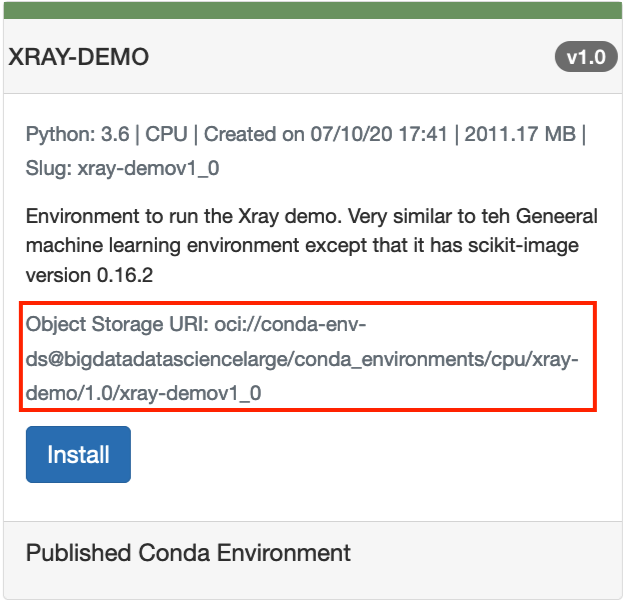

In [ ]:
# Creating a generic model artifact: 
artifact = prepare_generic_model(model_path,
                                 function_artifacts=False, 
                                 force_overwrite=True,
                                 inference_conda_env='<your-conda-path>')

In [ ]:
simple_model2._make_predict_function()

A new version of `score.py`: 

In [ ]:
%%writefile {model_path}/score.py 

import json
import os
import keras 
import numpy as np
from keras.models import load_model as klm 

model_name = 'xray_predictor4-march21.hdf5'

def load_model(model_file_name=model_name):
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    if model_file_name in contents:
        modelpath = os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name)
        tmp = klm(modelpath)
        tmp._make_predict_function()
        return tmp 
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))


def predict(data, model=load_model()):
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: {'prediction':output from model.predict method}

    """
    
    from pandas import read_json, DataFrame
    from io import StringIO
    X = read_json(StringIO(data))
    Xreshape = np.reshape(np.array(X['xrays'][0]),(1, 200, 300, 1))
    return {'prediction': model.predict_classes(Xreshape[:1]).tolist()}

Let's now test the artifact with a sample payload: 

In [ ]:
from json import load, dumps

with open("payload.json", 'r') as f: 
    payload = load(f)

and import the new `score.py` file we just created: 

In [ ]:
import sys
sys.path.insert(0, model_path)

from score import load_model, predict

_ = load_model()
predictions_test = predict(dumps(payload), _)
predictions_test

The file `runtime.yaml` does not need to be modified. ADS has already assigned values to all the parameters. 

## Saving the model artifact to the model catalog using ADS

The next step is to take that model artifact and save it to the model catalog. To do so, you will need to assign a project and compartment OCID to your model. An [OCID](https://docs.cloud.oracle.com/iaas/Content/General/Concepts/identifiers.htm) is an Oracle-assigned unique ID (Oracle Cloud Identifier -- OCID). It is included as part of the 
resources information in both the Console and the API. Note that projects, notebook sessions and models are OCI resources and consequently they have OCIDs too. 

We have included those values as environment variables in your notebook session. In fact you can access the following four OCIDs as environment variables: 

* `PROJECT_OCID`: Project OCID attached to this notebook session
* `NB_SESSION_OCID`: OCID of this notebook session
* `NB_SESSION_COMPARTMENT_OCID`: Compartment OCID of this notebook session 
* `USER_OCID`: Your user OCID. 

In the cell below we save the model in the same compartment as the notebook session and in the same project as the project associated with this notebook session. In principle, you can save your model into a different project and or compartment than the currently running notebook sessions: this allows you to isolate certain models in different compartments or use a dev-staging-prod approach to your models. 

## Saving the Model to the Model Catalog

The final step in this process is to save the model artifact to the model catalog. We will give it a name ("xray_cnn_model"). 

After saving the model let's go to the model catalog UI to see if the model is there. 

In [ ]:
# using resource principal to authenticate to the model catalog: 
ads.set_auth(auth='resource_principal')

compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ["PROJECT_OCID"]

In [ ]:
mc_model = artifact.save(project_id=project_id, compartment_id=compartment_id, display_name="xray_cnn_model",
                               description=f"Simple CNN model to classify xray images as having pneumonia or not",
                               training_script_path=f"./ChestXrays_Train.ipynb", 
                               ignore_pending_changes=True)
mc_model

# Deploy the Model with Data Science Model Deployment 

Here you have a couple of options: 
* you can deploy directly from the console **-or-** 
* you can use the OCI Python SDK to deploy the model programatically without leaving the notebook environment. 

The code snippet below will show how you can deploy using the Python SDK: 

In [ ]:
import oci 
from oci.data_science import DataScienceClient, DataScienceClientCompositeOperations

from oci.data_science.models import ModelConfigurationDetails, InstanceConfiguration, \
                                    FixedSizeScalingPolicy, CategoryLogDetails, LogDetails, \
                                    SingleModelDeploymentConfigurationDetails, CreateModelDeploymentDetails

A couple of ways to authenticate against model deployment. First one is through resource principals. Second one is to use the config + pem files in your notebook session. Pick the one that you want to use. 

In [ ]:
# using resource principals
auth = oci.auth.signers.get_resource_principals_signer()
data_science = DataScienceClient({}, signer=auth)

# OR the config + pem authn flow: 
#oci_config = oci.config.from_file('~/.oci/config', "DEFAULT")
#data_science = DataScienceClient(oci_config)

The cell below provides the necessary parameters for a model deployment. The first three parameters are standard to all the Data Science resources:   

In [ ]:
# Configuration of the model: 
# We deploy the sklearn model we saved to the model catalog in this notebook (catalog_entry.id)
# You can change the shape, instance_count, or the bandwidth of the load balancer (in Mbps)
model_configuration_details_object = ModelConfigurationDetails(model_id=mc_model.id,
                                                               instance_configuration=InstanceConfiguration(instance_shape_name='VM.Standard2.1'),
                                                               scaling_policy=FixedSizeScalingPolicy(instance_count=1),
                                                               bandwidth_mbps=10)

# Single Model Deployment Configuration
# Includes info about the deployment type and the model configuration details: 
# At the moment, only deployment+type='SINGLE_MODEL' is supported. 
single_model_config = SingleModelDeploymentConfigurationDetails(deployment_type='SINGLE_MODEL',
                                                                model_configuration_details=model_configuration_details_object)


# OPTIONAL - Configuration of the access and predict logs. 
# Make sure you have the proper policy in place to allow model deployment to emit predict/access logs. For example: 
# allow any-user to use log-content in tenancy where ALL {request.principal.type = 'datasciencemodeldeployment'}
logging_config = False
if logging_config: 

    access_log_group_id = "<your-log-group-id>"
    access_log_id = "<your-log-id>"
    predict_log_group_id = "<your-log-group-id>"
    predict_log_id = "<your-log-id>"

    logs_configuration_details_object = CategoryLogDetails(access=LogDetails(log_group_id=access_log_group_id,
                                                                             log_id=access_log_id),
                                                           predict=LogDetails(log_group_id=predict_log_group_id,
                                                                             log_id=predict_log_id))
else: 
    logs_configuration_details_object = {}


# Wrapping all of these configs into a model deploy configuration: 
# Replace with your own values for display_name, description, project, and compartment OCIDs 
model_deploy_configuration = CreateModelDeploymentDetails(display_name='pneumonia-detection-v2',
                                                          description='Detection of pneumonia(1/0) in xray images of the chest area',
                                                          project_id=os.environ['PROJECT_OCID'],
                                                          compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'],
                                                          model_deployment_configuration_details=single_model_config,
                                                          category_log_details=logs_configuration_details_object)

In [ ]:
# Creating a model deployment. This action takes a few minutes

data_science_composite = DataScienceClientCompositeOperations(data_science)
model_deployment = data_science_composite.create_model_deployment_and_wait_for_state(model_deploy_configuration, 
                                                                                     wait_for_states=["SUCCEEDED", "FAILED"])

# Invoking the Deployed Model

In [ ]:
import requests
import oci
from oci.signer import Signer
import numpy as np
from json import dumps

In [ ]:
# Insert your model deployment URI here: 
uri = "<model-deployment-uri>"
print(uri)

Displaying the image that we submit as payload to the model /predict endpoint

In [ ]:
with open('payload.json') as fp: 
    tmp = json.load(fp)
    npa = np.asarray(tmp['xrays']).reshape((200,300))
    plt.imshow(npa)

Next is to setup authn. Two options are given in the cell below: 
* you authenticate as the user (config+key flow) 
* you authenticate as the resource (in this case a notebook session) via resource principal 

By default, we use resource principal (`using_rps = True`) but you can change that value. We expect the oci config and pem files to be located under `~/.oci/`

In [ ]:
# using resource principals. You can alternatively use the config+key flow. 

# Using Resource principal to authenticate against the model endpoint. Set using_rps=False if you are using 
# the config+key flow. 
using_rps = True
endpoint = uri

# payload: 
#input_data = train[5:25].to_json()
#body = input_data

if using_rps: # using resource principal:     
    auth = oci.auth.signers.get_resource_principals_signer()
else: # using config + key: 
    config = oci.config.from_file("~/.oci/config") # replace with the location of your oci config file
    auth = Signer(
        tenancy=config['tenancy'],
        user=config['user'],
        fingerprint=config['fingerprint'],
        private_key_file_location=config['key_file'],
        pass_phrase=config['pass_phrase'])

Finally let's invoke the predict endpoint of the model. 

In [ ]:
%%time
# submit request to model endpoint: 
requests.post(endpoint, json=dumps(tmp), auth=auth).json()